In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics # Untuk F1 score

# Fuzzy System untuk Prediksi Asupan Karbohidrat
# 0. Pra-pemrosesan

In [2]:
carb_df = pd.read_csv('./fuzzy_macros_dataset_bmi.csv')
carb_df.head()

,BMI,BodyFat,Sex,Age,Protein_g,Calories_kcal,Fat_g,Carbohydrates_g
0,21.45,13.6,F,19,135.1,1801,60.0,180.1
1,23.53,8.8,M,57,161.2,2150,71.7,215.0
2,22.15,23.1,F,20,144.2,1923,64.1,192.3
3,23.61,11.9,M,32,189.7,2529,84.3,252.9
4,21.47,17.6,F,18,144.4,1925,64.2,192.5


In [3]:
# Informasi dasar dataset
carb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BMI              95 non-null     float64
 1   BodyFat          95 non-null     float64
 2   Sex              95 non-null     object 
 3   Age              95 non-null     int64  
 4   Protein_g        95 non-null     float64
 5   Calories_kcal    95 non-null     int64  
 6   Fat_g            95 non-null     float64
 7   Carbohydrates_g  95 non-null     float64
dtypes: float64(5), int64(2), object(1)
memory usage: 6.1+ KB


In [4]:
# Statistik deskriptif
carb_df.describe()

,BMI,BodyFat,Age,Protein_g,Calories_kcal,Fat_g,Carbohydrates_g
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,23.721579,18.813684,35.905263,162.116842,2161.578947,72.049474,216.157895
std,3.279800,7.392386,16.680396,22.646899,301.962291,10.063637,30.196229
min,17.640000,3.000000,18.000000,124.100000,1655.000000,55.200000,165.500000
25%,21.370000,13.750000,21.000000,144.500000,1926.500000,64.250000,192.650000
50%,23.400000,18.600000,32.000000,161.600000,2155.000000,71.800000,215.500000
75%,26.050000,23.950000,48.500000,177.800000,2370.500000,79.000000,237.050000
max,31.860000,34.700000,72.000000,212.000000,2827.000000,94.200000,282.700000


### Deteksi dan Penghapusan Outlier

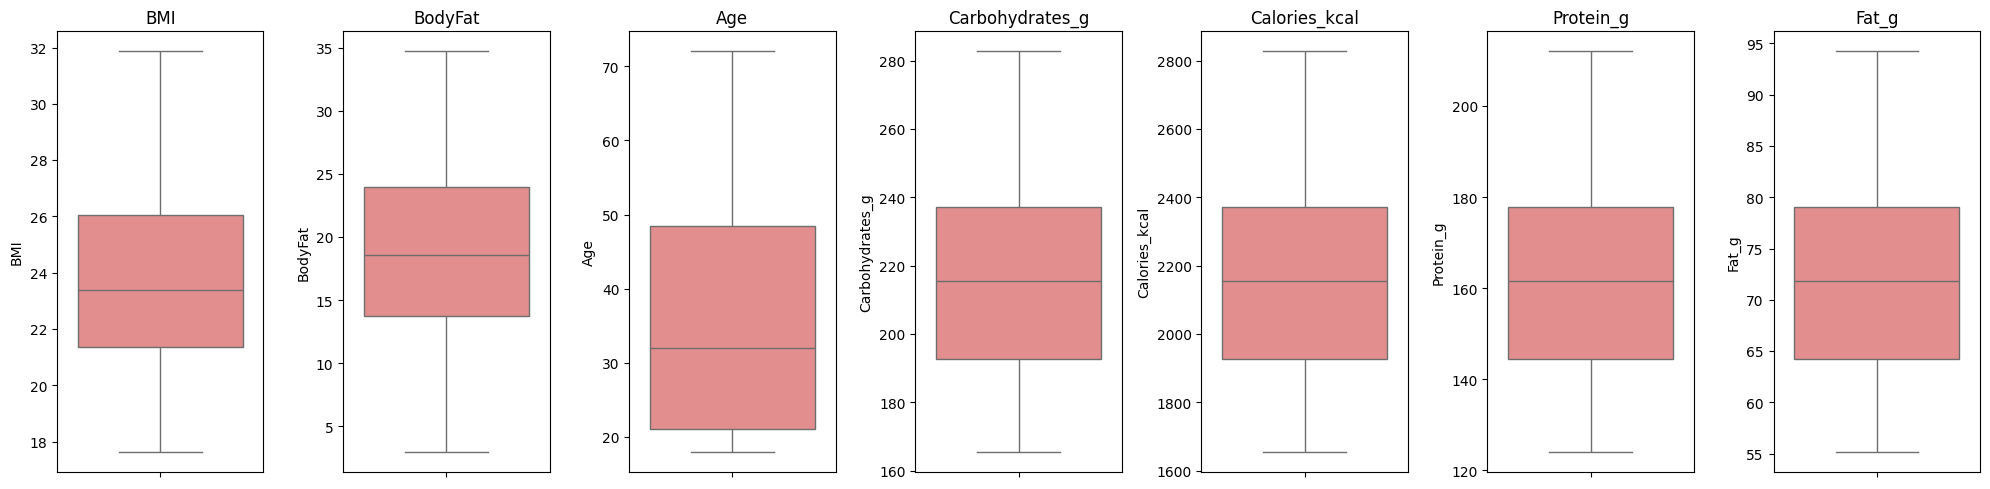

In [5]:
# Visualisasi persebaran data menggunakan boxplot untuk mengidentifikasi outlier
numeric_columns_check_carb = ['BMI', 'BodyFat', 'Age', 'Carbohydrates_g', 'Calories_kcal', 'Protein_g', 'Fat_g'] # Menambahkan Carbohydrates_g
n_check_carb = len(numeric_columns_check_carb)

plt.figure(figsize=(20, 5))

for i, column in enumerate(numeric_columns_check_carb): 
    plt.subplot(1, n_check_carb, i+1)
    sns.boxplot(y=carb_df[column], color='lightcoral')
    plt.title(column)

plt.tight_layout()
plt.show()

Analisis grafik persebaran data dan anomali dalam dataset: 

1.  **BMI**: Median sekitar 24-25. Beberapa outliers tinggi di atas 35.
2.  **BodyFat**: Median sekitar 20-21%. Beberapa outliers tinggi di atas 35-40%.
3.  **Age**: Distribusi cukup merata dengan median sekitar 35-40 tahun. Beberapa outliers di usia sangat tua (>70).
4.  **Carbohydrates_g**: Median sekitar 200g. Beberapa outliers tinggi (>350g) dan rendah (<50g).

Jumlah data sebelum penghapusan outlier IQR: 95
BMI: Dihapus 0 data outlier
BodyFat: Dihapus 0 data outlier
Age: Dihapus 0 data outlier
Carbohydrates_g: Dihapus 0 data outlier
Jumlah data setelah penghapusan outlier IQR: 95


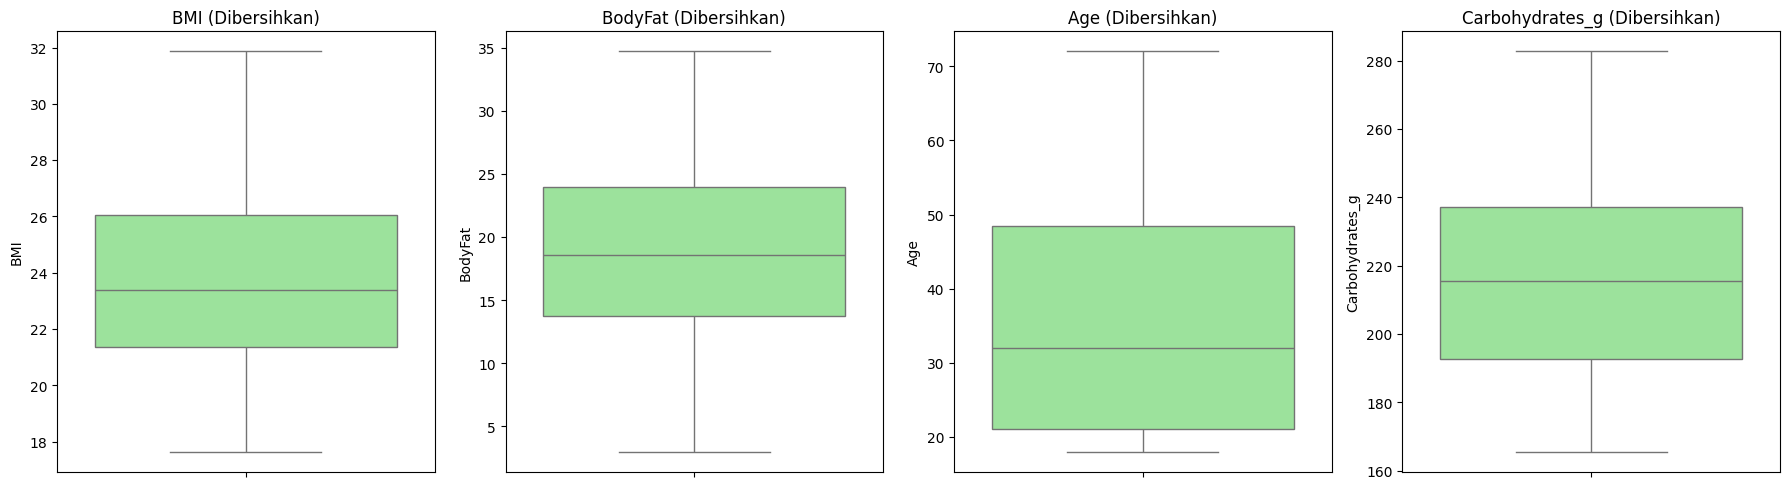

In [6]:
# Kolom yang relevan untuk sistem fuzzy (input + target)
relevant_columns_for_fuzzy_carb = ['BMI', 'BodyFat', 'Age', 'Carbohydrates_g'] 

# Filter dan menghapus data dari outlier dengan metode IQR (Interquartile Range)
df_cleaned_carb = carb_df.copy()
print(f"Jumlah data sebelum penghapusan outlier IQR: {df_cleaned_carb.shape[0]}")
for column in relevant_columns_for_fuzzy_carb:
    Q1 = df_cleaned_carb[column].quantile(0.25)
    Q3 = df_cleaned_carb[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    before_col = df_cleaned_carb.shape[0]
    df_cleaned_carb = df_cleaned_carb[(df_cleaned_carb[column] >= lower_bound) & (df_cleaned_carb[column] <= upper_bound)]
    after_col = df_cleaned_carb.shape[0]
    print(f"{column}: Dihapus {before_col - after_col} data outlier")
print(f"Jumlah data setelah penghapusan outlier IQR: {df_cleaned_carb.shape[0]}")

# Visualisasi persebaran data setelah menghapus outlier
plt.figure(figsize=(18, 5))
for i, column in enumerate(relevant_columns_for_fuzzy_carb): 
    plt.subplot(1, len(relevant_columns_for_fuzzy_carb), i+1)
    sns.boxplot(y=df_cleaned_carb[column], color='lightgreen')
    plt.title(f'{column} (Dibersihkan)')

plt.tight_layout()
plt.show()

### Pemfilteran Data Fisiologis
Berdasarkan `Fuzzy System Definition_Carbohydrate Intake.md`:
- Rentang Usia: [18, 80]
- Rentang BMI: [15, 50]
- Rentang BodyFat Pria: [2, 60]
- Rentang BodyFat Wanita: [10, 60]
- Rentang Carbohydrates_g: [100, 400]

Kita akan memfilter data agar tetap berada dalam rentang yang masuk akal untuk MF ini.

In [7]:
print(f"Jumlah data sebelum pemfilteran fisiologis: {df_cleaned_carb.shape[0]}")

# Filter Usia
df_cleaned_carb = df_cleaned_carb[(df_cleaned_carb['Age'] >= 18) & (df_cleaned_carb['Age'] <= 80)]

# Filter BMI
df_cleaned_carb = df_cleaned_carb[(df_cleaned_carb['BMI'] >= 15) & (df_cleaned_carb['BMI'] <= 50)]

# Filter BodyFat (berdasarkan jenis kelamin)
df_cleaned_carb = df_cleaned_carb[~((df_cleaned_carb['Sex'] == 'M') & ((df_cleaned_carb['BodyFat'] < 2) | (df_cleaned_carb['BodyFat'] > 60)))]
df_cleaned_carb = df_cleaned_carb[~((df_cleaned_carb['Sex'] == 'F') & ((df_cleaned_carb['BodyFat'] < 10) | (df_cleaned_carb['BodyFat'] > 60)))]

# Filter Carbohydrates_g (variabel target, untuk rentang evaluasi yang wajar)
# Menggunakan rentang yang sedikit lebih lebar dari MF untuk fleksibilitas dalam data aktual.
df_cleaned_carb = df_cleaned_carb[(df_cleaned_carb['Carbohydrates_g'] >= 50) & (df_cleaned_carb['Carbohydrates_g'] <= 500)] 

print(f"Jumlah data setelah pemfilteran fisiologis: {df_cleaned_carb.shape[0]}")

Jumlah data sebelum pemfilteran fisiologis: 95
Jumlah data setelah pemfilteran fisiologis: 94


# 1. Variabel Linguistik dan Fungsi Keanggotaan (MFs)

### Fungsi Pembantu untuk MFs

In [8]:
def trapmf(x, abcd):
    a, b, c, d = abcd
    if a > b: raise ValueError('a > b')
    if b > c: raise ValueError('b > c') # Allow b == c for triangular
    if c > d: raise ValueError('c > d')
        
    y = np.zeros_like(x if isinstance(x, np.ndarray) else [x])
    
    # Handle scalar input
    if not isinstance(x, np.ndarray):
        x = np.array([x])
        y = np.zeros_like(x, dtype=float)
        single_value = True
    else:
        y = np.zeros_like(x, dtype=float)
        single_value = False

    # Left slope
    if a != b:
        idx = np.logical_and(x >= a, x < b)
        y[idx] = (x[idx] - a) / (b - a)

    # Top part
    idx = np.logical_and(x >= b, x <= c)
    y[idx] = 1

    # Right slope
    if c != d:
        idx = np.logical_and(x > c, x <= d)
        y[idx] = (d - x[idx]) / (d - c)

    return y[0] if single_value else y
        
    return y[0] if isinstance(y, np.ndarray) and y.size == 1 else y

def trimf(x, abc):
    a, b, c = abc
    if a > b: raise ValueError('a > b dalam trimf')
    if b > c: raise ValueError('b > c dalam trimf')
    return trapmf(x, [a, b, b, c])

### Input: BMI (kg/m²)

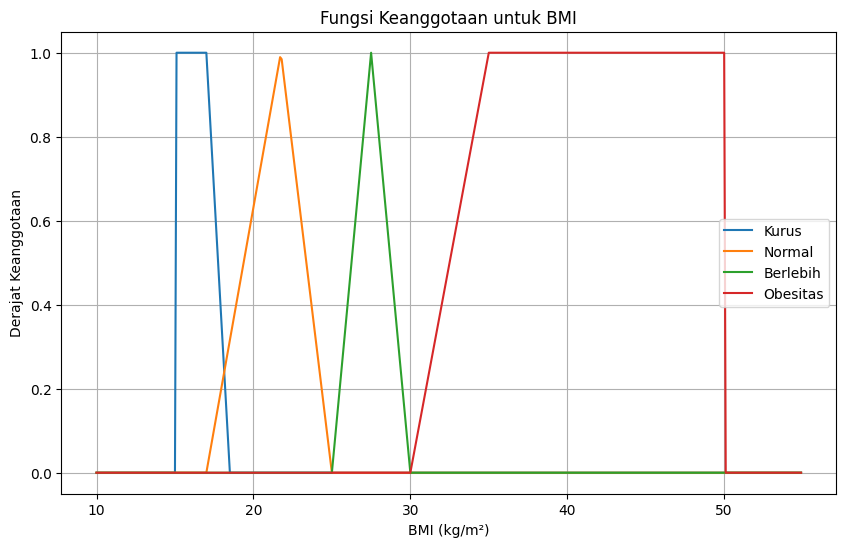

In [9]:
def bmi_underweight(bmi):
    return trapmf(bmi, [15, 15, 17, 18.5])

def bmi_normal(bmi):
    return trimf(bmi, [17, 21.75, 25])

def bmi_overweight(bmi):
    return trimf(bmi, [25, 27.5, 30])

def bmi_obese(bmi):
    return trapmf(bmi, [30, 35, 50, 50])

# Visualisasi MFs BMI
x_bmi_vis_carb = np.arange(10, 55, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_bmi_vis_carb, bmi_underweight(x_bmi_vis_carb), label='Kurus')
plt.plot(x_bmi_vis_carb, bmi_normal(x_bmi_vis_carb), label='Normal')
plt.plot(x_bmi_vis_carb, bmi_overweight(x_bmi_vis_carb), label='Berlebih')
plt.plot(x_bmi_vis_carb, bmi_obese(x_bmi_vis_carb), label='Obesitas')
plt.title('Fungsi Keanggotaan untuk BMI')
plt.xlabel('BMI (kg/m²)')
plt.ylabel('Derajat Keanggotaan')
plt.legend()
plt.grid(True)
plt.show()

### Input: Persentase Lemak Tubuh (Pria)

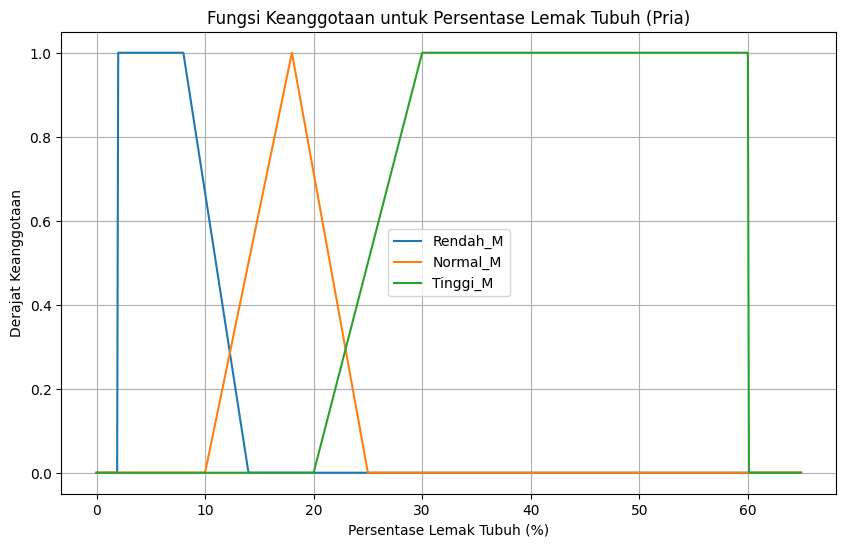

In [10]:
def bfm_lean(bodyfat):
    return trapmf(bodyfat, [2, 2, 8, 14])

def bfm_normal(bodyfat):
    return trimf(bodyfat, [10, 18, 25])

def bfm_high(bodyfat):
    return trapmf(bodyfat, [20, 30, 60, 60])

# Visualisasi MFs BodyFat Pria
x_bf_m_vis_carb = np.arange(0, 65, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_bf_m_vis_carb, bfm_lean(x_bf_m_vis_carb), label='Rendah_M')
plt.plot(x_bf_m_vis_carb, bfm_normal(x_bf_m_vis_carb), label='Normal_M')
plt.plot(x_bf_m_vis_carb, bfm_high(x_bf_m_vis_carb), label='Tinggi_M')
plt.title('Fungsi Keanggotaan untuk Persentase Lemak Tubuh (Pria)')
plt.xlabel('Persentase Lemak Tubuh (%)')
plt.ylabel('Derajat Keanggotaan')
plt.legend()
plt.grid(True)
plt.show()

### Input: Persentase Lemak Tubuh (Wanita)

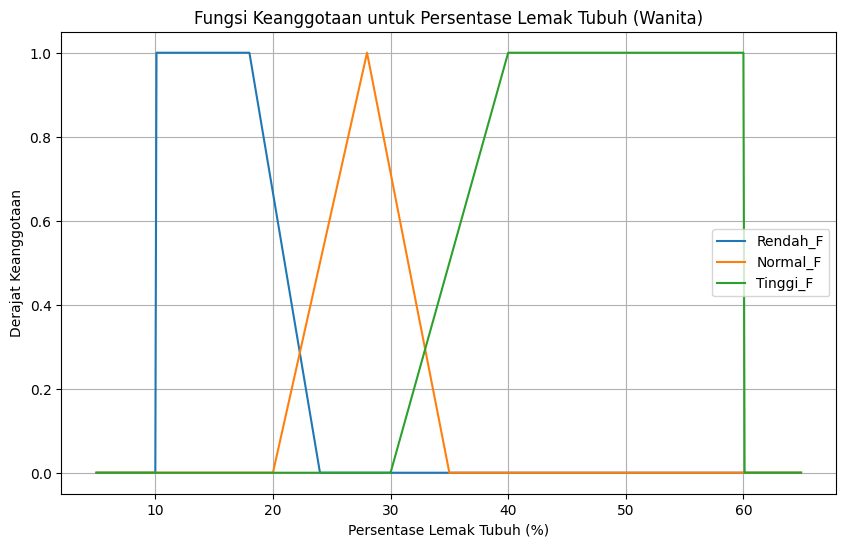

In [11]:
def bfw_lean(bodyfat):
    return trapmf(bodyfat, [10, 10, 18, 24])

def bfw_normal(bodyfat):
    return trimf(bodyfat, [20, 28, 35])

def bfw_high(bodyfat):
    return trapmf(bodyfat, [30, 40, 60, 60])

# Visualisasi MFs BodyFat Wanita
x_bf_f_vis_carb = np.arange(5, 65, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_bf_f_vis_carb, bfw_lean(x_bf_f_vis_carb), label='Rendah_F')
plt.plot(x_bf_f_vis_carb, bfw_normal(x_bf_f_vis_carb), label='Normal_F')
plt.plot(x_bf_f_vis_carb, bfw_high(x_bf_f_vis_carb), label='Tinggi_F')
plt.title('Fungsi Keanggotaan untuk Persentase Lemak Tubuh (Wanita)')
plt.xlabel('Persentase Lemak Tubuh (%)')
plt.ylabel('Derajat Keanggotaan')
plt.legend()
plt.grid(True)
plt.show()

### Input: Usia (tahun)

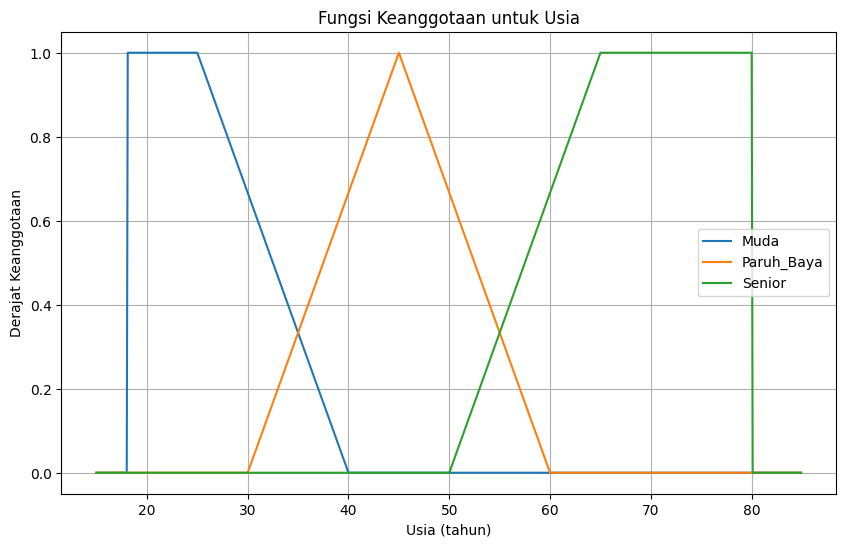

In [12]:
def age_young(age):
    return trapmf(age, [18, 18, 25, 40])

def age_middle(age):
    return trimf(age, [30, 45, 60])

def age_senior(age):
    return trapmf(age, [50, 65, 80, 80])

# Visualisasi MFs Usia
x_age_vis_carb = np.arange(15, 85, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_age_vis_carb, age_young(x_age_vis_carb), label='Muda')
plt.plot(x_age_vis_carb, age_middle(x_age_vis_carb), label='Paruh_Baya')
plt.plot(x_age_vis_carb, age_senior(x_age_vis_carb), label='Senior')
plt.title('Fungsi Keanggotaan untuk Usia')
plt.xlabel('Usia (tahun)')
plt.ylabel('Derajat Keanggotaan')
plt.legend()
plt.grid(True)
plt.show()

### Output: Asupan Karbohidrat (g)

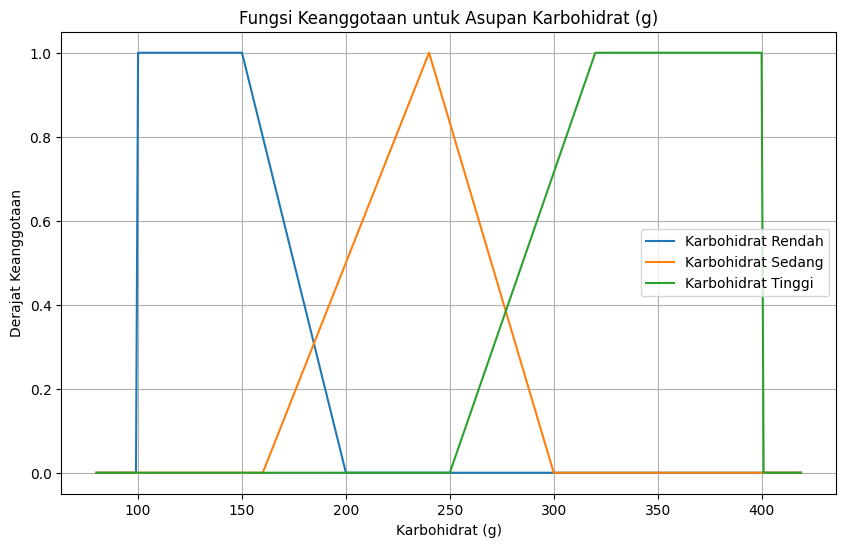

In [13]:
# MFs Mamdani untuk Karbohidrat
def carb_low_mf(carbs):
    return trapmf(carbs, [100, 100, 150, 200])

def carb_medium_mf(carbs):
    return trimf(carbs, [160, 240, 300])

def carb_high_mf(carbs):
    return trapmf(carbs, [250, 320, 400, 400])

# Konstanta Sugeno untuk Karbohidrat
carb_sugeno_constants = {
    'Low': 150,
    'Medium': 240,
    'High': 320
}

# Visualisasi MFs Karbohidrat (Mamdani)
x_carb_vis_output = np.arange(80, 420, 1)
plt.figure(figsize=(10, 6))
plt.plot(x_carb_vis_output, carb_low_mf(x_carb_vis_output), label='Karbohidrat Rendah')
plt.plot(x_carb_vis_output, carb_medium_mf(x_carb_vis_output), label='Karbohidrat Sedang')
plt.plot(x_carb_vis_output, carb_high_mf(x_carb_vis_output), label='Karbohidrat Tinggi')
plt.title('Fungsi Keanggotaan untuk Asupan Karbohidrat (g)')
plt.xlabel('Karbohidrat (g)')
plt.ylabel('Derajat Keanggotaan')
plt.legend()
plt.grid(True)
plt.show()

# 2. Fuzzifikasi

In [14]:
bmi_mf_terms = {
    'Underweight': bmi_underweight,
    'Normal': bmi_normal,
    'Overweight': bmi_overweight,
    'Obese': bmi_obese
}

bodyfat_m_mf_terms = { # Pria
    'Lean_M': bfm_lean, 
    'Normal_M': bfm_normal, 
    'High_M': bfm_high
}

bodyfat_f_mf_terms = { # Wanita
    'Lean_F': bfw_lean, 
    'Normal_F': bfw_normal, 
    'High_F': bfw_high
}

age_mf_terms = {
    'Young': age_young,
    'Middle': age_middle,
    'Senior': age_senior
}

carb_output_mamdani_terms = {
    'Low': carb_low_mf,
    'Medium': carb_medium_mf,
    'High': carb_high_mf
}

In [15]:
def fuzzify_inputs_carb(bmi, bodyfat, sex, age):
    fuzz_bmi = {term: mf(bmi) for term, mf in bmi_mf_terms.items()}
    
    if sex == 'M':
        fuzz_bf = {term: mf(bodyfat) for term, mf in bodyfat_m_mf_terms.items()}
    else: # sex == 'F'
        fuzz_bf = {term: mf(bodyfat) for term, mf in bodyfat_f_mf_terms.items()}
        
    fuzz_age = {term: mf(age) for term, mf in age_mf_terms.items()}
    
    return fuzz_bmi, fuzz_bf, fuzz_age

# Contoh fuzzifikasi untuk sistem Karbohidrat
example_bmi_carb_fuzz = 28
example_bf_carb_fuzz = 30
example_sex_carb_fuzz = 'F'
example_age_carb_fuzz = 50

f_bmi_carb_ex, f_bf_carb_ex, f_age_carb_ex = fuzzify_inputs_carb(example_bmi_carb_fuzz, example_bf_carb_fuzz, example_sex_carb_fuzz, example_age_carb_fuzz)
print(f"Fuzzifikasi BMI untuk {example_bmi_carb_fuzz}: {f_bmi_carb_ex}")
print(f"Fuzzifikasi BodyFat ({example_sex_carb_fuzz}) untuk {example_bf_carb_fuzz}%: {f_bf_carb_ex}")
print(f"Fuzzifikasi Usia untuk {example_age_carb_fuzz} tahun: {f_age_carb_ex}")

Fuzzifikasi BMI untuk 28: {'Underweight': np.float64(0.0), 'Normal': np.float64(0.0), 'Overweight': np.float64(0.8), 'Obese': np.float64(0.0)}
Fuzzifikasi BodyFat (F) untuk 30%: {'Lean_F': np.float64(0.0), 'Normal_F': np.float64(0.7142857142857143), 'High_F': np.float64(0.0)}
Fuzzifikasi Usia untuk 50 tahun: {'Young': np.float64(0.0), 'Middle': np.float64(0.6666666666666666), 'Senior': np.float64(0.0)}


# 3. Mesin Inferensi (Evaluasi Aturan)

In [16]:
# Aturan untuk Asupan Karbohidrat dari Fuzzy System Definition_Carbohydrate Intake.md
# (Jenis Kelamin, Istilah_BMI, Istilah_BodyFat, Istilah_Usia, Istilah_Output_Karbohidrat)
carb_rules = [
    # Pria
    ('M', 'Underweight', 'Lean_M', 'Young', 'Medium'),
    ('M', 'Underweight', 'Lean_M', 'Middle', 'Medium'),
    ('M', 'Underweight', 'Lean_M', 'Senior', 'Low'),
    ('M', 'Underweight', 'Normal_M', 'Young', 'Medium'),
    ('M', 'Underweight', 'Normal_M', 'Middle', 'Low'),
    ('M', 'Underweight', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Underweight', 'High_M', 'Young', 'Low'),
    ('M', 'Underweight', 'High_M', 'Middle', 'Low'),
    ('M', 'Underweight', 'High_M', 'Senior', 'Low'),
    ('M', 'Normal', 'Lean_M', 'Young', 'High'),
    ('M', 'Normal', 'Lean_M', 'Middle', 'High'),
    ('M', 'Normal', 'Lean_M', 'Senior', 'Medium'),
    ('M', 'Normal', 'Normal_M', 'Young', 'High'),
    ('M', 'Normal', 'Normal_M', 'Middle', 'Medium'),
    ('M', 'Normal', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Normal', 'High_M', 'Young', 'Medium'),
    ('M', 'Normal', 'High_M', 'Middle', 'Low'),
    ('M', 'Normal', 'High_M', 'Senior', 'Low'),
    ('M', 'Overweight', 'Lean_M', 'Young', 'High'),
    ('M', 'Overweight', 'Lean_M', 'Middle', 'High'),
    ('M', 'Overweight', 'Lean_M', 'Senior', 'Medium'),
    ('M', 'Overweight', 'Normal_M', 'Young', 'High'),
    ('M', 'Overweight', 'Normal_M', 'Middle', 'High'),
    ('M', 'Overweight', 'Normal_M', 'Senior', 'Medium'),
    ('M', 'Overweight', 'High_M', 'Young', 'Medium'),
    ('M', 'Overweight', 'High_M', 'Middle', 'Medium'),
    ('M', 'Overweight', 'High_M', 'Senior', 'Low'),
    ('M', 'Obese', 'Lean_M', 'Young', 'High'),
    ('M', 'Obese', 'Lean_M', 'Middle', 'Medium'),
    ('M', 'Obese', 'Lean_M', 'Senior', 'Low'),
    ('M', 'Obese', 'Normal_M', 'Young', 'High'),
    ('M', 'Obese', 'Normal_M', 'Middle', 'Medium'),
    ('M', 'Obese', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Obese', 'High_M', 'Young', 'Medium'),
    ('M', 'Obese', 'High_M', 'Middle', 'Low'),
    ('M', 'Obese', 'High_M', 'Senior', 'Low'),
    # Wanita
    ('F', 'Underweight', 'Lean_F', 'Young', 'Medium'),
    ('F', 'Underweight', 'Lean_F', 'Middle', 'Low'),
    ('F', 'Underweight', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Young', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Middle', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Underweight', 'High_F', 'Young', 'Low'),
    ('F', 'Underweight', 'High_F', 'Middle', 'Low'),
    ('F', 'Underweight', 'High_F', 'Senior', 'Low'),
    ('F', 'Normal', 'Lean_F', 'Young', 'High'),
    ('F', 'Normal', 'Lean_F', 'Middle', 'Medium'),
    ('F', 'Normal', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Normal', 'Normal_F', 'Young', 'Medium'),
    ('F', 'Normal', 'Normal_F', 'Middle', 'Medium'),
    ('F', 'Normal', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Normal', 'High_F', 'Young', 'Low'),
    ('F', 'Normal', 'High_F', 'Middle', 'Low'),
    ('F', 'Normal', 'High_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'Lean_F', 'Young', 'High'),
    ('F', 'Overweight', 'Lean_F', 'Middle', 'Medium'),
    ('F', 'Overweight', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'Normal_F', 'Young', 'High'),
    ('F', 'Overweight', 'Normal_F', 'Middle', 'Medium'),
    ('F', 'Overweight', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'High_F', 'Young', 'Medium'),
    ('F', 'Overweight', 'High_F', 'Middle', 'Low'),
    ('F', 'Overweight', 'High_F', 'Senior', 'Low'),
    ('F', 'Obese', 'Lean_F', 'Young', 'Medium'),
    ('F', 'Obese', 'Lean_F', 'Middle', 'Low'),
    ('F', 'Obese', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Obese', 'Normal_F', 'Young', 'Medium'),
    ('F', 'Obese', 'Normal_F', 'Middle', 'Low'),
    ('F', 'Obese', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Obese', 'High_F', 'Young', 'Low'),
    ('F', 'Obese', 'High_F', 'Middle', 'Low'),
    ('F', 'Obese', 'High_F', 'Senior', 'Low'),
]

In [17]:
def apply_carb_rules(fuzz_bmi, fuzz_bf, fuzz_age, sex_input):
    aggregated_mamdani_strengths = {term: 0.0 for term in carb_output_mamdani_terms}
    sugeno_rule_outputs = []
    active_rules_details_list = []

    for rule_sex, bmi_term, bf_term, age_term, carb_consequent_term in carb_rules:
        if rule_sex != sex_input:
            continue

        bmi_strength = fuzz_bmi.get(bmi_term, 0)
        bf_strength = fuzz_bf.get(bf_term, 0)
        age_strength = fuzz_age.get(age_term, 0)
        
        rule_strength = min(bmi_strength, bf_strength, age_strength)
        
        if rule_strength > 0:
            active_rules_details_list.append({
                'Sex': rule_sex,
                'BMI Term': bmi_term, 'BMI Strength': bmi_strength,
                'BF Term': bf_term, 'BF Strength': bf_strength,
                'Age Term': age_term, 'Age Strength': age_strength,
                'Carb Consequent': carb_consequent_term,
                'Rule Strength': rule_strength
            })
            
            aggregated_mamdani_strengths[carb_consequent_term] = max(
                aggregated_mamdani_strengths[carb_consequent_term], rule_strength
            )
            
            sugeno_consequent_value = carb_sugeno_constants[carb_consequent_term]
            sugeno_rule_outputs.append((rule_strength, sugeno_consequent_value))
            
    return aggregated_mamdani_strengths, sugeno_rule_outputs, pd.DataFrame(active_rules_details_list)

In [18]:
# Contoh aplikasi aturan untuk Karbohidrat
agg_mamdani_carb, sug_outputs_carb, active_rules_carb_df = apply_carb_rules(f_bmi_carb_ex, f_bf_carb_ex, f_age_carb_ex, example_sex_carb_fuzz)
print("Kekuatan Mamdani Teragregasi (Karbohidrat):", agg_mamdani_carb)
print("\nOutput Aturan Sugeno (Karbohidrat - kekuatan, nilai konsekuen):", sug_outputs_carb)
print("\nDetail Aturan Aktif (Karbohidrat):")
if not active_rules_carb_df.empty:
    display(active_rules_carb_df)
else:
    print("Tidak ada aturan yang aktif untuk input yang diberikan.")

Kekuatan Mamdani Teragregasi (Karbohidrat): {'Low': 0.0, 'Medium': np.float64(0.6666666666666666), 'High': 0.0}

Output Aturan Sugeno (Karbohidrat - kekuatan, nilai konsekuen): [(np.float64(0.6666666666666666), 240)]

Detail Aturan Aktif (Karbohidrat):


,Sex,BMI Term,BMI Strength,BF Term,BF Strength,Age Term,Age Strength,Carb Consequent,Rule Strength
0,F,Overweight,0.8,Normal_F,0.714286,Middle,0.666667,Medium,0.666667


# 4. Defuzzifikasi

### 4.1 Mamdani (Centroid)

In [19]:
carb_universe_defuzz_mamdani = np.arange(100, 401, 1) # Semesta output karbohidrat untuk defuzzifikasi

def defuzzify_mamdani_centroid_carb(aggregated_strengths, output_universe):
    numerator = 0
    denominator = 0
    aggregated_mf_plot_values = np.zeros_like(output_universe, dtype=float)

    for i, carb_val in enumerate(output_universe):
        max_membership_for_carb_val = 0
        for carb_term, strength in aggregated_strengths.items():
            if strength > 0:
                clipped_value = min(carb_output_mamdani_terms[carb_term](carb_val), strength)
                max_membership_for_carb_val = max(max_membership_for_carb_val, clipped_value)
        aggregated_mf_plot_values[i] = max_membership_for_carb_val
        numerator += carb_val * max_membership_for_carb_val
        denominator += max_membership_for_carb_val
        
    if denominator == 0:
        return 0 
    return numerator / denominator

In [20]:
# Contoh defuzzifikasi Mamdani untuk Karbohidrat
mamdani_carb_prediction = defuzzify_mamdani_centroid_carb(agg_mamdani_carb, carb_universe_defuzz_mamdani)
print(f"Prediksi Karbohidrat (Centroid Mamdani): {mamdani_carb_prediction:.2f}g")

Prediksi Karbohidrat (Centroid Mamdani): 232.78g


### 4.2 Sugeno (Rata-rata Tertimbang)

In [21]:
def defuzzify_sugeno_weighted_average_carb(sugeno_rule_outputs_list):
    # sugeno_rule_outputs_list adalah daftar (kekuatan, nilai_konsekuen)
    numerator = 0
    denominator = 0
    
    if not sugeno_rule_outputs_list:
        return 0
        
    for strength, consequent_value in sugeno_rule_outputs_list:
        numerator += strength * consequent_value
        denominator += strength
        
    if denominator == 0:
        return 0
        
    return numerator / denominator

In [22]:
# Contoh defuzzifikasi Sugeno untuk Karbohidrat
sugeno_carb_prediction = defuzzify_sugeno_weighted_average_carb(sug_outputs_carb)
print(f"Prediksi Karbohidrat (Rata-rata Tertimbang Sugeno): {sugeno_carb_prediction:.2f}g")

Prediksi Karbohidrat (Rata-rata Tertimbang Sugeno): 240.00g


# 5. Evaluasi

In [23]:
mamdani_carb_predictions_eval = []
sugeno_carb_predictions_eval = []
actual_carb_values_eval = []

for index, row in df_cleaned_carb.iterrows():
    bmi_val = row['BMI']
    bodyfat_val = row['BodyFat']
    sex_val = row['Sex']
    age_val = row['Age']
    actual_carb = row['Carbohydrates_g']
    
    f_bmi, f_bf, f_age = fuzzify_inputs_carb(bmi_val, bodyfat_val, sex_val, age_val)
    agg_mamdani_str, sug_outputs_list, _ = apply_carb_rules(f_bmi, f_bf, f_age, sex_val)
    
    mamdani_pred = defuzzify_mamdani_centroid_carb(agg_mamdani_str, carb_universe_defuzz_mamdani)
    sugeno_pred = defuzzify_sugeno_weighted_average_carb(sug_outputs_list)
    
    mamdani_carb_predictions_eval.append(mamdani_pred)
    sugeno_carb_predictions_eval.append(sugeno_pred)
    actual_carb_values_eval.append(actual_carb)

df_cleaned_carb['Carb_Mamdani_Predicted'] = mamdani_carb_predictions_eval
df_cleaned_carb['Carb_Sugeno_Predicted'] = sugeno_carb_predictions_eval

print("\n--- Contoh Karbohidrat Aktual vs Prediksi (dengan prediksi) ---")
print(df_cleaned_carb[['Carbohydrates_g', 'Carb_Mamdani_Predicted', 'Carb_Sugeno_Predicted']].head())


--- Contoh Karbohidrat Aktual vs Prediksi (dengan prediksi) ---
   Carbohydrates_g  Carb_Mamdani_Predicted  Carb_Sugeno_Predicted
0            180.1              340.123172             320.000000
1            215.0              266.930773             264.528302
2            192.3              262.542691             262.325581
3            252.9              307.254613             307.512195
4            192.5              340.181003             320.000000


In [24]:
# Evaluasi F1 Score untuk Karbohidrat
# Bin berdasarkan titik tengah konstanta Sugeno: Rendah hingga (150+240)/2 = 195; Sedang hingga (240+320)/2 = 280; Tinggi di atasnya
carb_bins_edges_f1 = [0, 195, 280, float('inf')]
carb_labels_f1 = [0, 1, 2] # Mewakili Rendah, Sedang, Tinggi

actual_carb_binned_f1 = pd.cut(df_cleaned_carb['Carbohydrates_g'], bins=carb_bins_edges_f1, labels=carb_labels_f1, include_lowest=True, duplicates='drop')
mamdani_carb_binned_f1 = pd.cut(df_cleaned_carb['Carb_Mamdani_Predicted'], bins=carb_bins_edges_f1, labels=carb_labels_f1, include_lowest=True, duplicates='drop')
sugeno_carb_binned_f1 = pd.cut(df_cleaned_carb['Carb_Sugeno_Predicted'], bins=carb_bins_edges_f1, labels=carb_labels_f1, include_lowest=True, duplicates='drop')

# Hapus nilai NA
valid_indices_mamdani_carb_f1 = actual_carb_binned_f1.notna() & mamdani_carb_binned_f1.notna()
valid_indices_sugeno_carb_f1 = actual_carb_binned_f1.notna() & sugeno_carb_binned_f1.notna()

if valid_indices_mamdani_carb_f1.sum() > 0 and len(np.unique(actual_carb_binned_f1[valid_indices_mamdani_carb_f1])) > 1:
    f1_mamdani_carb = metrics.f1_score(actual_carb_binned_f1[valid_indices_mamdani_carb_f1], mamdani_carb_binned_f1[valid_indices_mamdani_carb_f1], average='macro', zero_division=0)
    print(f"\nF1 Score (Mamdani Karbohidrat - Binned): {f1_mamdani_carb:.4f}")
else:
    print("\nTidak dapat menghitung F1 score Mamdani untuk Karbohidrat karena data tidak mencukupi atau hanya ada satu kelas.")

if valid_indices_sugeno_carb_f1.sum() > 0 and len(np.unique(actual_carb_binned_f1[valid_indices_sugeno_carb_f1])) > 1:
    f1_sugeno_carb = metrics.f1_score(actual_carb_binned_f1[valid_indices_sugeno_carb_f1], sugeno_carb_binned_f1[valid_indices_sugeno_carb_f1], average='macro', zero_division=0)
    print(f"F1 Score (Sugeno Karbohidrat - Binned): {f1_sugeno_carb:.4f}")
else:
    print("\nTidak dapat menghitung F1 score Sugeno untuk Karbohidrat karena data tidak mencukupi atau hanya ada satu kelas.")


F1 Score (Mamdani Karbohidrat - Binned): 0.1615
F1 Score (Sugeno Karbohidrat - Binned): 0.1729


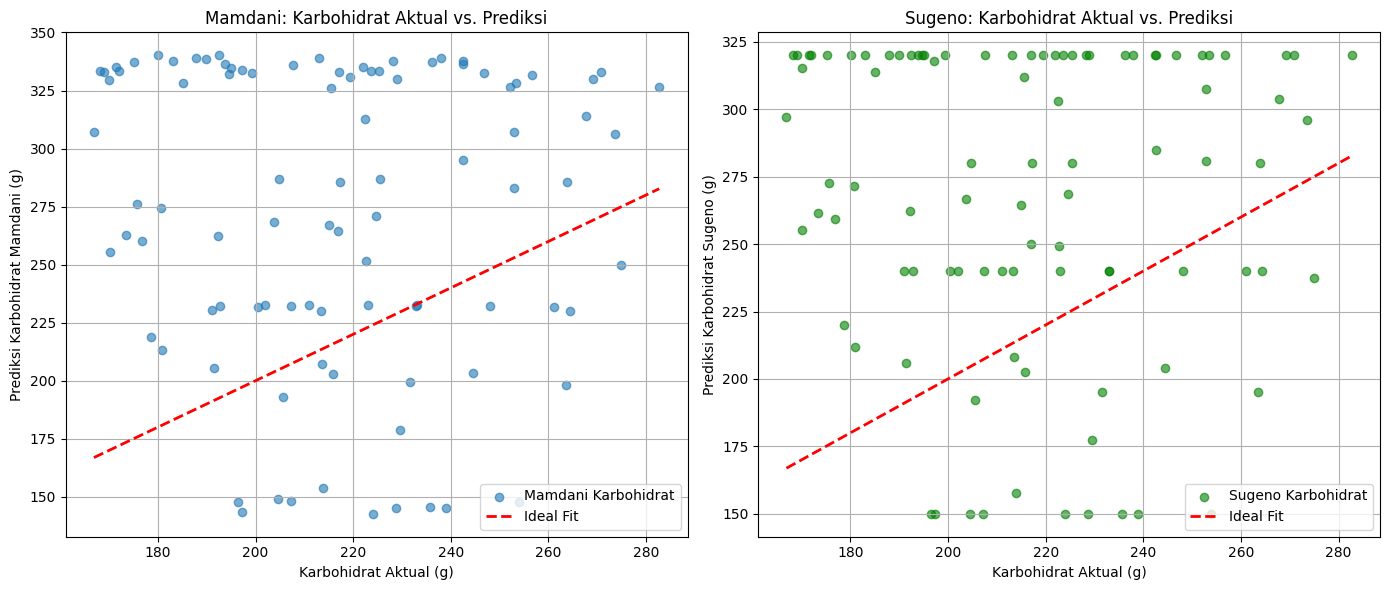

In [25]:
# Scatter plot Aktual vs. Prediksi Karbohidrat
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_cleaned_carb['Carbohydrates_g'], df_cleaned_carb['Carb_Mamdani_Predicted'], alpha=0.6, label='Mamdani Karbohidrat')
plt.plot([df_cleaned_carb['Carbohydrates_g'].min(), df_cleaned_carb['Carbohydrates_g'].max()], 
         [df_cleaned_carb['Carbohydrates_g'].min(), df_cleaned_carb['Carbohydrates_g'].max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Karbohidrat Aktual (g)')
plt.ylabel('Prediksi Karbohidrat Mamdani (g)')
plt.title('Mamdani: Karbohidrat Aktual vs. Prediksi')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(df_cleaned_carb['Carbohydrates_g'], df_cleaned_carb['Carb_Sugeno_Predicted'], alpha=0.6, color='green', label='Sugeno Karbohidrat')
plt.plot([df_cleaned_carb['Carbohydrates_g'].min(), df_cleaned_carb['Carbohydrates_g'].max()], 
         [df_cleaned_carb['Carbohydrates_g'].min(), df_cleaned_carb['Carbohydrates_g'].max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Karbohidrat Aktual (g)')
plt.ylabel('Prediksi Karbohidrat Sugeno (g)')
plt.title('Sugeno: Karbohidrat Aktual vs. Prediksi')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()